# Evaluating Predictive Models: Logistic Regression versus Neural Networks in Traffic Accident Data Analysis

### Abstract

------

## Introduction

This report details the process of analyzing and preparing a dataset for predictive modeling, focusing on reducing multicollinearity, merging features, and evaluating model performance.

**Deep Belief Networks** (DBN) ...


- Requirements: Packages used to run the analysis and global variables

In [6]:
#  Packages for data manipulation and processing
import numpy as np                      # list and matrix calculation
import pandas as pd                     # csv file processing

# Supervied leraning analysis tools
import torch                                    
import torch.nn as nn                           # neural network moduls
import torch.optim as optim                     # optimizer in NN
from torch.nn import Dropout, BatchNorm1d       # Net structures

from torch.utils.data import TensorDataset, DataLoader # data load related libs
from torch.utils.data import Dataset            # training dataset class
from torch.utils.data import random_split       # randomly split a dataset into multiple subsets

from sklearn.preprocessing import LabelEncoder  # encode target value to label
from sklearn.model_selection import train_test_split # single split dataset
from sklearn.model_selection import KFold       # cross-validation
from sklearn.decomposition import PCA           # PCA for Dimensionality Reduction
# Import logistic regression method
from sklearn.linear_model import LogisticRegression 
# Model evaluation tools
from sklearn.metrics import accuracy_score

# Data analysis tools
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Calculate vif

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns                   # built-in themes to draw attractive and informative statistical graphics.

## Literature review

In predictive modeling, feature engineering and selection play critical roles. Techniques like Variance Inflation Factor (VIF) analysis help identify and mitigate multicollinearity, improving model accuracy and interpretability.

Merging correlated features can also streamline models, making them more efficient.

##  Methodology

Data Preprocessing

Variance Inflation Factor Calculation: Used to identify features with high multicollinearity, potentially distorting model results. Features with a VIF exceeding 10 are considered highly collinear and are thus candidates for removal or alteration.
Feature Merging: Combines similar or related features to reduce the feature space and potentially enhance model performance.

Model Training and Evaluation

Model Training: Conducts training over several epochs to optimize performance metrics.
Cross-Validation Setup: Utilizes KFold strategy to ensure that model evaluation is robust and not biased towards a particular subset of the data.

In [7]:
# raw data relative path
collisionDataPath = "./data/dft-road-casualty-statistics-collision-last-5-years.csv"
casualtyDataPath = "./data/dft-road-casualty-statistics-casualty-last-5-years.csv"
# dtype: str location indicator of raw data
dtype_specification = {0: str, 2: str, 18: str}

### Data gathering
[Ref](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/)

In [8]:

# Dataset class def
class TrainDataset(Dataset):

    def __init__(self, path, loc_remove:list[str], loc_test=None, dtype:dict=None):
        """
        Training dataset initialization method used to convert the data frame from csv file
        into list array style that can be used for batch seperation.
        
        Parameters
        ------
        path : str, pd.DataFrame
            The relative file path of dataset
            Can also input data frame directly
        loc_remove : list[str]
            The columns will be removed
        loc_test : list[str], optinal
            The index of testing columns
        dtype : dict, optional
            The specific data type of column(s)
        """
        # load the csv file as a dataframe
        if(isinstance(path, pd.DataFrame)):
            df = path
        else:
            df = pd.read_csv(path, dtype=dtype)
        # remove useless columns
        df = df.drop(columns=loc_remove)
        # print first row to preview df
        df.head(1)
        # stroe the df
        self.raw = df
        # The training and testing data
        self.X = None
        self.y = None
        self.test = loc_test

    def __len__(self):
        """
        Check the size of dataset.

        Return
        ------
        len(self.X) : int
            The size of X
        """
        print(f"Training dataset length: {len(self.X)}, test dataset length: {len(self.y)}")
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    def get_train_test_split(self):
        # store the inputs and outputs
        if self.test is None:
            self.X = self.raw.values[:, :-1]
            self.y = self.raw.values[:, -1]
        else:
            self.X = self.raw.drop(columns=self.test).to_numpy()
            self.y = self.raw[self.test].values.ravel()
            # NotImplementedError()
        # label encode target
        self.y = LabelEncoder().fit_transform(self.y)
        # ensure output data is floats
        self.y = self.y.astype('float32')
        # reshapes output array to have len(self.y) rows and 1 column
        self.y = self.y.reshape((len(self.y), 1))

    def reset_raw_data(self, new_df, loc_test=None):
        self.raw = new_df
        if loc_test is not None:
            self.test = loc_test
        # Assign X and y
        self.get_train_test_split()

    def shape(self):
        return self.raw.shape

    def describe(self, cols: list[str]=None):
        """
        generates descriptive statistics that summarize the df.

        Parameter
        ------
        cols: list[str]
            specific clumns that will be described
        """
        if cols is not None:
            print(self.raw[cols].describe(include='all'))
        else:
            print(self.raw.describe(include='all'))

    def clean_na(self):
        """
        data processing step. 
        Remove rows with any null values and replace '-1' with NaN,
        then remove any rows with NaN values.
        """
        self.raw = self.raw.dropna()
        self.raw = self.raw.replace(-1, pd.NA).dropna()
        self.raw = self.raw.replace('-1', pd.NA).dropna()

    def get_splits(self, n_test=0.33):
        """
        split the dataset and get indexes for train and test rows.

        Parameter
        ------
        n_test : float
            The split ratio of testing dataset [0, 1]
        """
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

### Data pre-processing

Checking the note in the data readme file, -1 means there is a data fail to be recored or out of the range.

In [9]:
casualtyDataset = TrainDataset(casualtyDataPath, loc_remove=['accident_index', 'accident_year', 
       'vehicle_reference', 'casualty_reference',
       'pedestrian_road_maintenance_worker', 'lsoa_of_casualty'],
             dtype=dtype_specification)
collisionDataset = TrainDataset(collisionDataPath, loc_remove=['accident_index', 'accident_year',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'date', 'time', 'local_authority_district',
       'local_authority_ons_district', 'local_authority_highway', 'first_road_number', 
       'second_road_number', 'did_police_officer_attend_scene_of_accident',
       'lsoa_of_accident_location'],
       dtype=dtype_specification)

casualtyDataset.clean_na()
collisionDataset.clean_na()

In [10]:
"""
The target columns are: 'casualty_severity', 'road_type'
However, the y column that used for prediction has to be one dismension.
Therefor, a look up table that saves the combination of these two columns has
to be created.
"""

def get_look_up_table(list1, list2):
    lookup_table = {}
    counter = 0
    # Map each unique pair to a unique integer, incrementing sequentially.
    for item1 in list1:
        for item2 in list2:
            lookup_table[(item1, item2)] = counter
            counter += 1
    return lookup_table

lookup_table = get_look_up_table([1, 2, 3], [1, 2, 3, 4, 5, 6, 7, 9])
# Print the lookup table
for pair, value in lookup_table.items():
    print(f"Pair: {pair}, Value: {value}")

# Apply the lookup table to each row
def lookup_value(row, class1='accident_severity', class2='special_conditions_at_site'):
    try:
        return lookup_table[(row[class1], row[class2])]
    except KeyError as e:
        # print(f"KeyError for row: {row.to_dict()}")
        return None

Pair: (1, 1), Value: 0
Pair: (1, 2), Value: 1
Pair: (1, 3), Value: 2
Pair: (1, 4), Value: 3
Pair: (1, 5), Value: 4
Pair: (1, 6), Value: 5
Pair: (1, 7), Value: 6
Pair: (1, 9), Value: 7
Pair: (2, 1), Value: 8
Pair: (2, 2), Value: 9
Pair: (2, 3), Value: 10
Pair: (2, 4), Value: 11
Pair: (2, 5), Value: 12
Pair: (2, 6), Value: 13
Pair: (2, 7), Value: 14
Pair: (2, 9), Value: 15
Pair: (3, 1), Value: 16
Pair: (3, 2), Value: 17
Pair: (3, 3), Value: 18
Pair: (3, 4), Value: 19
Pair: (3, 5), Value: 20
Pair: (3, 6), Value: 21
Pair: (3, 7), Value: 22
Pair: (3, 9), Value: 23


In [11]:
# Merge the casulty and collision data set together by right
collision_casualty_merged = pd.merge(casualtyDataset.raw, collisionDataset.raw, how='right', on='accident_reference')
# Check how many null values existed in merged result
print(collision_casualty_merged.isnull().sum())

# Appl look up table to combine two classes together
collision_casualty_merged['labels'] = collision_casualty_merged.apply(lookup_value, axis=1)
# Get final dataset used for trainning
dataSet = TrainDataset(collision_casualty_merged, loc_remove=['accident_reference', 'casualty_severity', 'casualty_type',
                                                            'accident_severity', 'road_type'],
                       loc_test=['labels'])

accident_reference                             0
casualty_class                             23796
sex_of_casualty                            23796
age_of_casualty                            23796
age_band_of_casualty                       23796
casualty_severity                          23796
pedestrian_location                        23796
pedestrian_movement                        23796
car_passenger                              23796
bus_or_coach_passenger                     23796
casualty_type                              23796
casualty_home_area_type                    23796
casualty_imd_decile                        23796
accident_severity                              0
number_of_vehicles                             0
number_of_casualties                           0
day_of_week                                    0
first_road_class                               0
road_type                                      0
speed_limit                                    0
junction_detail     

### Data table reference

| Column                   | Type   | Description                | Count |
|--------------------------|--------|----------------------------|-------|
| age_band_of_casualty     | int    | Age band of the casualty   | 23796 |
| casualty_severity        | int    | Severity of the casualty   | 23796 |
| pedestrian_location      | int    | Location of the pedestrian | 23796 |
| pedestrian_movement      | int    | Movement of the pedestrian | 23796 |
| car_passenger            | int    | Car passenger indicator    | 23796 |
| bus_or_coach_passenger   | int    | Bus or coach passenger indicator | 23796 |
| casualty_type            | int    | Type of casualty           | 23796 |
| casualty_home_area_type  | int    | Home area type of casualty | 23796 |
| casualty_imd_decile      | int    | IMD decile for casualty    | 23796 |


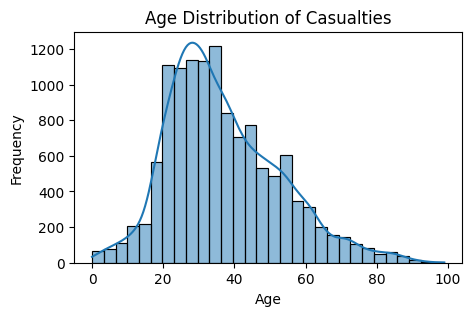

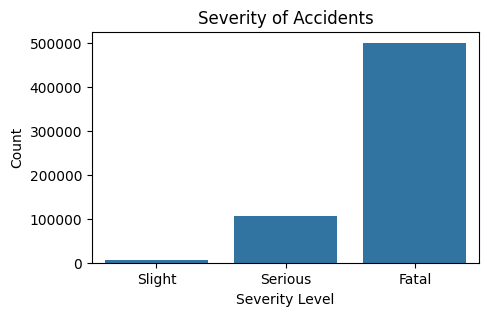

Text(0, 0.5, 'Casualty Type')

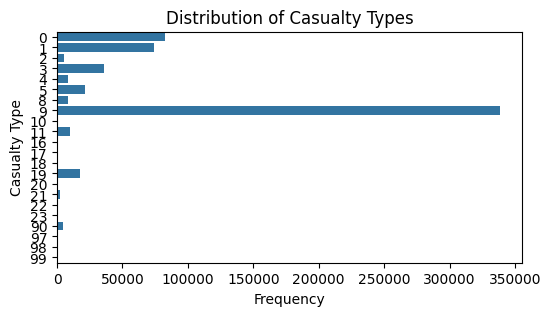

In [13]:
# Ensure proper rendering of plots
%matplotlib inline
# # 1. Trend of Accidents Over Years
# plt.figure(figsize=(10, 6))
# sns.countplot(x='accident_year', data=df)
# plt.title('Trend of Accidents Over Years')
# plt.ylabel('Number of Accidents')
# plt.xlabel('Year')
# plt.xticks(rotation=45)
# plt.show()

# 2. Age Distribution of Casualties
plt.figure(figsize=(5, 3))
sns.histplot(dataSet.raw['age_of_casualty'], bins=30, kde=True)
plt.title('Age Distribution of Casualties')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# 3. Severity of Accidents
plt.figure(figsize=(5, 3))
sns.countplot(x='casualty_severity', data=casualtyDataset.raw)
plt.title('Severity of Accidents')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Slight', 'Serious', 'Fatal'])
plt.show()

# 4. Casualty Type Distribution
plt.figure(figsize=(6, 3))
# Count the frequency of each casualty type
casualty_type_counts = casualtyDataset.raw['casualty_type'].value_counts().sort_values(ascending=False)
# Plot as a bar chart
sns.barplot(x=casualty_type_counts.values, y=casualty_type_counts.index, orient='h')
plt.title('Distribution of Casualty Types')
plt.xlabel('Frequency')
plt.ylabel('Casualty Type')

## Data preparation

In [12]:
# Remove Null and invalid value
dataSet.clean_na()
dataSet.get_train_test_split()

print(dataSet.shape())

(12383, 28)


In [14]:
def calculate_vif(df):
    # Calculating VIF for each independent variable
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    print(vif_data)
    return vif_data

def remove_multicollinear_columns(df, vif_threshold=10.0):
    """
    Removes columns from the dataframe df that have a variance inflation factor (VIF) greater than the threshold.
    """
    # Calculate VIF for each feature
    vif_data = calculate_vif(df)
    
    # Find features with VIF exceeding the threshold
    features_to_drop = vif_data[vif_data['VIF'] > vif_threshold]['feature']
    
    # Drop the features from the original dataframe
    df_reduced = df.drop(columns=features_to_drop)
    
    return df_reduced, features_to_drop

There are too many x-properties that going to be used, combining some of them together may benifit the model.

In [15]:
# merge similar data columns into one singe column
dataSet.raw['casualty_state'] = dataSet.raw['casualty_home_area_type'] * dataSet.raw['casualty_imd_decile']
dataSet.raw['pedestarin_crossing_state'] = dataSet.raw['pedestrian_crossing_human_control'] + dataSet.raw['pedestrian_crossing_physical_facilities']

# remove above used columns
dropColumns = ['casualty_home_area_type', 'casualty_imd_decile', 
               'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities']

# drop
dataSet.raw = dataSet.raw.drop(dropColumns, axis=1)
# re-assign the df back to object
dataSet.reset_raw_data(dataSet.raw, loc_test=['labels'])

display(dataSet.raw.head(6))

,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,number_of_vehicles,number_of_casualties,...,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,trunk_road_flag,labels,casualty_state,pedestarin_crossing_state
74,1.0,1,25,5,0,0,0,0,1,1,...,1,1,2,3,0,1,2,18.0,3,5
80,1.0,1,26,6,0,0,0,0,2,1,...,4,1,1,9,0,1,2,23.0,1,10
88,2.0,1,35,6,0,0,2,0,2,2,...,4,2,2,1,0,1,2,8.0,7,7
89,1.0,1,29,6,0,0,0,0,2,2,...,4,2,2,1,0,1,2,8.0,8,7
104,1.0,2,34,6,0,0,0,0,2,1,...,1,8,1,9,0,1,2,23.0,2,18
126,1.0,2,43,7,0,0,0,0,2,1,...,1,1,1,4,0,1,2,19.0,10,0


In [16]:
# Remove y-axis first
df_raw = dataSet.raw.drop('labels', axis=1)
# convert the data into numeric fromat to ensure the correct process
df_raw = df_raw.apply(pd.to_numeric, errors='coerce')
# get reduced df after appplying VIF remove
df_raw_fited, _ = remove_multicollinear_columns(df_raw, 10)
# add the dropped Y label column back again
df_raw_fited['labels'] = dataSet.raw['labels']
# re-assign the df back to object
dataSet.reset_raw_data(df_raw_fited, loc_test=['labels'])

                       feature         VIF
0               casualty_class   16.205190
1              sex_of_casualty    9.487878
2              age_of_casualty  109.051526
3         age_band_of_casualty  223.559719
4          pedestrian_location    4.970332
5          pedestrian_movement    4.799570
6                car_passenger    1.339246
7       bus_or_coach_passenger    1.164591
8           number_of_vehicles   13.767863
9         number_of_casualties    4.362550
10                 day_of_week    5.562628
11            first_road_class   11.977441
12                 speed_limit   16.129751
13             junction_detail    2.492458
14            junction_control    8.260491
15           second_road_class   18.452355
16            light_conditions    2.433905
17          weather_conditions    4.116873
18     road_surface_conditions    4.310155
19  special_conditions_at_site   11.722536
20         carriageway_hazards    3.286148
21         urban_or_rural_area   20.516884
22         

In [17]:
# Data split into training and testing sets with a 7:3 ratio
train_X, test_X, train_y, test_y = train_test_split(dataSet.X, dataSet.y, test_size=0.3, random_state=2024)

print(f"Training data shape: {dataSet.X.shape}")
print(f"Testing data shape: {dataSet.y.shape}")

Training data shape: (12383, 15)
Testing data shape: (12383, 1)


In [31]:
dataSet.raw.to_csv("final.csv")

In [18]:
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# min(n_samples, n_features)=15 (0, 15]
pca = PCA(n_components=10, svd_solver='auto')   # Reducedprincipal components
train_X = pca.fit_transform(train_X)            # Fit the model with X and apply the dimensionality reduction on X
test_X = pca.transform(test_X)                  # Apply dimensionality reduction to X

Reasons why choose logistic regression

'saga' solver is also suitable for large datasets and supports L1 regularization, which is helpfull in a high-dimensional dataset.

In [19]:
# Instantiate the model
logreg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100)

# Train the model
logreg.fit(train_X, train_y.ravel())

# Predict on the test set
y_pred = logreg.predict(test_X)

# Evaluate the model
print("Accuracy:", accuracy_score(test_y, y_pred))


Accuracy: 0.5843876177658143


e:\python_37\python_prj\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [52]:
# Define the neural network models
class Model_1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_1, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_classes)
        # No softmax here, CrossEntropyLoss will handle that

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer_out(x)  # Outputs are logits
        return x
    
class Model_2(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.5):
        super(Model_2, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.layer_out = nn.Linear(64, num_classes)
        # No softmax here, CrossEntropyLoss will handle that

    def forward(self, x):
        x = self.layer1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_out(x)  # Outputs are logits
        return x

In [21]:
def torch_training_start(model, train_loader, criterion, optimizer, epochs=5):
    print("Start training...")
    # Train the model
    for epoch in range(epochs):

        for inputs, targets in train_loader:
            if inputs.size(0) > 1:  # Check if batch size is greater than 1
                inputs, targets = inputs.float(), targets.long()  # Ensure correct types
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                # print("Encountered batch size of 1, skipping...")
                continue
                
        # print current training state    
        print(f"epoch: {epoch}, Loss: {loss.item()}")    

def model_eval(model_loaded, X_test_tensor, y_test_tensor):
    """
    Evaluate the model
    """
    model_loaded.eval()
    with torch.no_grad():
        outputs = model_loaded(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy * 100:.2f}%')

In [57]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(train_X.astype('float32'), dtype=torch.float32)
X_test_tensor = torch.tensor(test_X.astype('float32'), dtype=torch.float32)
y_train_tensor = torch.squeeze(torch.tensor(train_y, dtype=torch.long))
y_test_tensor = torch.squeeze(torch.tensor(test_y, dtype=torch.long))

print("Unique labels in train_y:", torch.unique(y_train_tensor))

# Define the dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_size = train_X.shape[1]
print(f"The shape of training data is: {input_size}")
# The number of classes
num_classes = 24        # After observing the unique labes, there are 0-23 total 24 classes
hidden_size = 128
epochs = 20

model = Model_2(input_size=input_size, num_classes=num_classes)
# model = Model_4(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

isTrain = True # Debug option, change to True if u want to train the model

if not isTrain:
    model_loaded = torch.load('model_4.pth')
    model_eval(model_loaded, X_test_tensor, y_test_tensor)
else:
    torch_training_start(model, train_loader, criterion, optimizer, epochs=epochs)

    model_eval(model, X_test_tensor, y_test_tensor)

    # Make predictions (on unseen data)
    with torch.no_grad():
        sample_data = X_test_tensor[:5]
        sample_preds = model(sample_data)
        _, predicted_classes = torch.max(sample_preds, 1)
    print(f'Predicted classes: {predicted_classes.numpy()}')

Unique labels in train_y: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21])
The shape of training data is: 10
Start training...
epoch: 0, Loss: 1.7386659383773804
epoch: 1, Loss: 1.9115318059921265
epoch: 2, Loss: 1.5237140655517578
epoch: 3, Loss: 1.4047759771347046
epoch: 4, Loss: 1.7716642618179321
epoch: 5, Loss: 2.6184940338134766
epoch: 6, Loss: 1.2717519998550415
epoch: 7, Loss: 1.5165413618087769
epoch: 8, Loss: 1.5758781433105469
epoch: 9, Loss: 1.7131766080856323
epoch: 10, Loss: 1.738637924194336
epoch: 11, Loss: 1.2814748287200928
epoch: 12, Loss: 1.3132312297821045
epoch: 13, Loss: 1.5209729671478271
epoch: 14, Loss: 1.6316099166870117
epoch: 15, Loss: 1.1663037538528442
epoch: 16, Loss: 1.9813135862350464
epoch: 17, Loss: 1.4134174585342407
epoch: 18, Loss: 1.1829482316970825
epoch: 19, Loss: 1.7725692987442017
Accuracy: 59.11%
Predicted classes: [17 21 21 17 21]


5 epoch training:

Model 1 merged columns result: 59.68%

Model 2 merged columns result: 61.47%

Model 3 merged columns result: 60.97%

Model 4 merged columns result: 60.80%

In [58]:
torch.save(model, 'model_2.pth')

For cross-validation, KFold or StratifiedKFold from sklearn.model_selection, which splits the dataset into k consecutive folds, will be used. Each fold is then used once as a validation while the $k-1$ remaining folds form the training set. This process is repeated $k$ times (folds), with each of the $k$ folds used exactly once as the validation data.

In [14]:
# Setup cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=2024)

# Example: Print the indices of the data for each fold
for train_index, test_index in kf.split(dataset.X):
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = dataset.X[train_index], dataset.X[test_index]
    y_train, y_test = dataset.y[train_index], dataset.y[test_index]

Train: [     0      1      2 ... 538456 538459 538460] Test: [     4      6      7 ... 538448 538457 538458]
Train: [     1      3      4 ... 538457 538458 538460] Test: [     0      2      5 ... 538453 538455 538459]
Train: [     0      2      3 ... 538458 538459 538460] Test: [     1      8     13 ... 538441 538447 538454]
Train: [     0      1      2 ... 538457 538458 538459] Test: [     3     14     16 ... 538450 538451 538460]
Train: [     0      1      2 ... 538458 538459 538460] Test: [     9     10     19 ... 538438 538439 538456]


## Bibliography